In [74]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

In [75]:
def theta3_from_a(a, tol=1e-14, nmax=100000):
    """
    Evaluate θ3(0, e^{-a}) robustly using modular transformation when needed.
    a > 0.
    θ3(0,q) = 1 + 2 * sum_{n=1}^\infty q^{n^2}, q = exp(-a).
    """
    if a <= 0:
        raise ValueError("Parameter 'a' must be positive.")
    # Map q = exp(-π t) form: here a = π t  => t = a/π
    t = a / math.pi
    if t < 1.0:
        # Use modular transformation: θ3(0, e^{-π t}) = t^{-1/2} θ3(0, e^{-π/t})
        t_inv = 1.0 / t
        q_small = math.exp(-math.pi * t_inv)
        # Fast convergence since q_small is tiny
        s = 1.0
        n = 1
        term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        return s / math.sqrt(t)
    else:
        # Direct series
        q = math.exp(-math.pi * t)
        s = 1.0
        n = 1
        term = 2.0 * q ** (n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * q ** (n * n)
        return s

def G_of_rho(rho):
    # G(ρ) = θ3(e^{-ρ^2}) / θ3(e^{-ρ^2/2})^2
    a1 = rho**2
    a2 = rho**2 / 2.0
    th1 = theta3_from_a(a1)
    th2 = theta3_from_a(a2)
    return th1 / (th2**2)

def M2_of_rho(rho):
    """
    Dimensionless second moment for discrete Gaussian weights.
    For small rho, use continuum asymptotic 1/rho^2 (accurate up to exponentially small error).
    Otherwise compute via truncated symmetric sum.
    """
    if rho < 0.05:
        return 1.0 / (rho**2)
    # Choose truncation based on width ~ 1/rho. Take 6 sigma-equivalent.
    M = max(10, int(math.ceil(8.0 / rho)))
    # Symmetric sum; m=0 contributes to Z only
    Z = 1.0
    num = 0.0
    c = -0.5 * rho**2
    for m in range(1, M+1):
        w = math.exp(c * m * m)
        Z += 2.0 * w
        num += 2.0 * (m*m) * w
    return num / Z

def mu2_of_rho(rho, dQ):
    # μ2(ρ) = ΔQ^2 * M2(ρ)
    return (dQ**2) * M2_of_rho(rho)


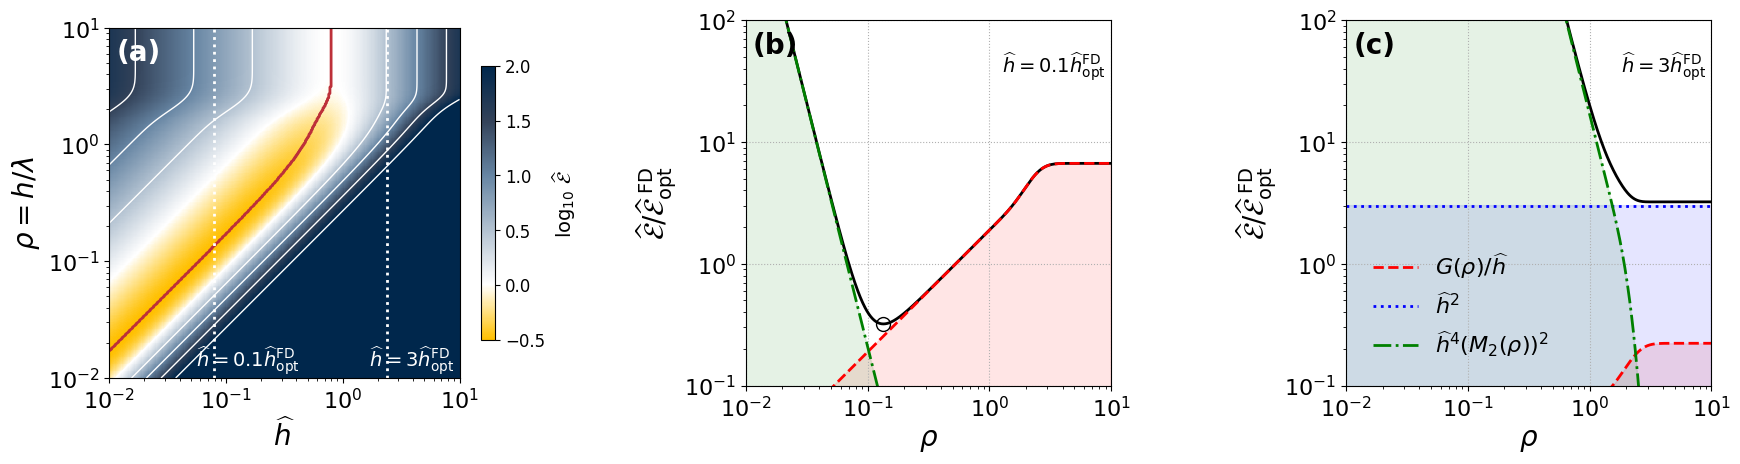

In [98]:

# --- parameter grids (broaden + densify) ---
dQ_vals  = np.logspace(-3, 1, 401)   # \widehat{h}
rho_vals = np.logspace(-2, 1, 401) # \rho

chi = 1.0  # use the correct chi!

# Baseline ρ grid to evaluate and find the red-path minimum
rho_all = np.logspace(-2, 1, 400)

# Paths
dQ_FD = 2.0 ** (-1.0/3.0)
pref_small = (1.0 / (8.0 * np.sqrt(np.pi) * chi)) ** (1.0/5.0)
dQ_small_all = rho_all * pref_small

# Evaluate total reduced error along each path on the wide grid
E_FD_all = np.empty_like(rho_all)
E_small_all = np.empty_like(rho_all)
for i, rho in enumerate(rho_all):
    G = G_of_rho(rho)
    mu2_FD = mu2_of_rho(rho, dQ_FD)
    mu2_small = mu2_of_rho(rho, dQ_small_all[i])
    E_FD_all[i] = G / dQ_FD + dQ_FD**2 + mu2_FD**2
    E_small_all[i] = G / dQ_small_all[i] + dQ_small_all[i]**2 + mu2_small**2

rho_extreme = 1e4 
E_FD_extreme = G_of_rho(rho_extreme) / dQ_FD + dQ_FD**2 + mu2_of_rho(rho_extreme, dQ_FD)**2

# --- compute reduced error surface (NO normalization here) ---
Z = np.empty((rho_vals.size, dQ_vals.size), float)
Z1 = np.empty((rho_vals.size, dQ_vals.size), float)
Z2 = np.empty((rho_vals.size, dQ_vals.size), float)
Z3 = np.empty((rho_vals.size, dQ_vals.size), float)
for i, rho in enumerate(rho_vals):
    G = G_of_rho(rho)
    for j, dQ in enumerate(dQ_vals):
        mu2 = mu2_of_rho(rho, dQ)       # see note at the top
        Z1[i, j] = G / dQ
        Z2[i, j] = dQ**2
        Z3[i, j] = chi * (mu2**2)
        Z[i, j] = G / dQ + dQ**2 + chi * (mu2**2)

# --- detect interior minima via derivative sign-change w.r.t. dQ ---
dQ_min_list = []
rho_min_list = []
E_min_list = []
for i, rho in enumerate(rho_vals):
    Z_row = Z[i, :]
    dZ_ddQ = np.gradient(Z_row, dQ_vals)
    sign_changes = np.where(np.diff(np.sign(dZ_ddQ)))[0]
    idx_min = np.argmin(Z_row)
    dQ_min_list.append(dQ_vals[idx_min])
    rho_min_list.append(rho)
    E_min_list.append(Z_row[idx_min])
E_min_list = np.array(E_min_list)
dQ_min_list = np.array(dQ_min_list)
rho_min_list = np.array(rho_min_list)

X, Y = np.meshgrid(dQ_vals, rho_vals)

# ----------------------------
# Asymptotic optimal lines \widehat{h}_{opt}(\rho)
# ----------------------------
# Large-ρ (weak/no smoothing): \widehat{h}_{opt} = 2^{-1/3}
dQ_opt_large = 2.0 ** (-1.0/3.0)

# Small-ρ (strong smoothing): \widehat{h}_{opt} ~ ρ * (1/(8 sqrt(pi) χ))^{1/5}
# Eq. (\ref{eq:opt-small-rho})
pref_small = (1.0 / (8.0 * np.sqrt(np.pi) * chi)) ** (1.0/5.0)
dQ_opt_small_curve = rho_vals * pref_small

# ----------------------------
# Plot
# ----------------------------
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

contour_colors = ['w', 'w', 'w', 'w', 'w', 'w']
CS = ax1.contour(X, Y, np.log10(Z/E_FD_extreme), levels=np.linspace(-0.5, 2.0001, 6), linewidths=1, colors=contour_colors, linestyles='-')
# Define a custom colormap using a given color series
# colors = ['#00274C', '#FFFFFF', '#FFF0C0', '#FFE080', '#FFD040', '#FFC000']  # Blue to White to Red
colors = ['#FFC000', '#FFFFFF', '#B3C2D1', '#6685A3', '#334259', '#00274C']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
CSf = ax1.pcolormesh(X, Y, np.log10(Z/E_FD_extreme), vmax=2, vmin=-0.5, shading='nearest', cmap=custom_cmap)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$\widehat{h}$', fontsize=20)
ax1.set_ylabel(r'$\rho=h/\lambda$', fontsize=20)
ax1.set_aspect('equal', adjustable='box')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.text(0.02, 0.97, '(a)', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='left', color='w')

ax1.plot(dQ_min_list[rho_min_list<13], rho_min_list[rho_min_list<13], '-', color='#BD3039', lw=2, label=r'$\widehat{h}_\mathrm{opt}(\rho)$ (small $\rho$)')

# semi-transparent rectangular patch in data coordinates (works with log scales)
cross_over_high = 3
cross_over_low = 1

# ax1.plot([1e-2, 1e1], [cross_over_high, cross_over_high], 'w:', lw=2)
# ax1.plot([1e-2, 1e1], [cross_over_low, cross_over_low], 'w:', lw=2)
# ax1.plot([dQ_opt_large, dQ_opt_large], [1e-2, cross_over_low], 'w:', lw=2)

# ax1.text(0.5, np.sqrt(30), 'I', color='k', fontsize=26, va='center', ha='center')
# ax1.text(6e-2, 0.2, 'II', color='k', fontsize=26, va='center', ha='center')
# ax1.text(5e-3, 0.03, 'III', color='k', fontsize=26, va='center', ha='center')
# ax1.text(3e0, 0.1, 'IV', color='w', fontsize=26, va='center', ha='center')
# ax1.text(0.3, np.sqrt(cross_over_low* cross_over_high), 'V', color='k', fontsize=26, va='center', ha='center')

ax1.set_xlim(1e-2, 1e1)
ax1.set_ylim(1e-2, 1e1)

# Colorbar
# cax = fig.add_subplot(gs[1])
# cbar = plt.colorbar(CSf, cax=cax)
cbar = plt.colorbar(CSf, ax=ax1, shrink=0.75)
cbar.set_label(r'$\log_{10}\,\widehat{\mathcal{E}}\,$', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# # Overlay the region with the dominated term among Z1, Z2, Z3
# dominant_term = np.argmax(np.stack([Z1, Z2, Z3], axis=0), axis=0)

# # Define colors for each dominated region
# dominant_colors = {0: '#FFAAAA', 1: '#AAAAFF', 2: '#AAFFAA'}  # Red, Blue, Green
# dominant_cmap = ListedColormap([dominant_colors[i] for i in range(3)])

# # Plot the dominant region
# ax1.pcolormesh(X, Y, dominant_term, shading='nearest', cmap=dominant_cmap, alpha=0.3)

# cross section slices at fixed dQ
dQ_vals_slice = [dQ_opt_large * 0.1, dQ_opt_large * 3]
rho_vals_fine = np.logspace(-2, 1, 601)
current_slice = 0
for ax, dQ, panel_label in zip([ax2, ax3], dQ_vals_slice, ['(b)', '(c)']):
    E_vals = []
    E_vals_n1 = []
    E_vals_2 = []
    E_vals_4 = []
    for rho in rho_vals_fine:
        G = G_of_rho(rho)
        mu2 = mu2_of_rho(rho, dQ)
        val = G / dQ + dQ**2 + mu2**2
        E_vals.append(val)
        E_vals_n1.append(G / dQ)
        E_vals_2.append(dQ**2)
        E_vals_4.append(mu2**2)
    E_vals = np.array(E_vals)
    E_vals_n1 = np.array(E_vals_n1)
    E_vals_2 = np.array(E_vals_2)
    E_vals_4 = np.array(E_vals_4)
    #
    color = (0.2, 0.7, 0.2)  # green-ish
    label = f"$\\widehat{{h}}/\\widehat{{h}}_{{\\mathrm{{opt}}}}^{{\\mathrm{{FD}}}}={dQ/dQ_opt_large:.2g}$"
    if np.isclose(dQ, dQ_opt_large):
        label = r'$\widehat{h}=\widehat{h}_\mathrm{opt}^\mathrm{FD}$'
        color = 'b'
    elif dQ > dQ_opt_large:
        label = r'$\widehat{h} = 3 \widehat{h}_\mathrm{opt}^\mathrm{FD}$'
        color = '#22AAAA'
    else:
        label = r'$\widehat{h} = 0.1 \widehat{h}_\mathrm{opt}^\mathrm{FD}$'
        color = '#FF0000'
    ax.plot(rho_vals_fine, E_vals/E_FD_extreme, color='k', lw=2)
    # ax.plot(rho_vals_fine, E_vals/E_FD_extreme, '', label=label, color='w', lw=1e-6)
    ax.plot(rho_vals_fine, E_vals_n1/E_FD_extreme, color='r', linestyle='--', lw=2, label=r'$G(\rho)/\widehat{h}$')
    ax.fill_between(rho_vals_fine, E_vals_n1/E_FD_extreme, y2=1e-4, color='r', alpha=0.1)
    ax.plot(rho_vals_fine, E_vals_2/E_FD_extreme, color='b', linestyle=':', lw=2, label=r'$\widehat{h}^2$')
    ax.fill_between(rho_vals_fine, E_vals_2/E_FD_extreme, y2=1e-4, color='b', alpha=0.1)
    ax.plot(rho_vals_fine, E_vals_4/E_FD_extreme, color='g', linestyle='-.', lw=2, label=r'$\widehat{h}^4(M_2(\rho))^2$')
    ax.fill_between(rho_vals_fine, E_vals_4/E_FD_extreme, y2=1e-4, color='g', alpha=0.1)
    # Plot minimum for each slice
    E_vals = np.array(E_vals)
    idx_min = np.argmin(E_vals)
    if dQ<=dQ_opt_large:
        ax.plot(rho_vals_fine[idx_min], E_vals[idx_min]/E_FD_extreme, 'o', color='k', fillstyle='none', markersize=10)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-2, 1e1)
    ax.set_ylim(1e-1, 1e2)
    ax.set_xlabel(r'$\rho$', fontsize=20)
    ax.set_ylabel(r'$\widehat{\mathcal{E}}/\widehat{\mathcal{E}}_\mathrm{opt}^\mathrm{\ FD}$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.grid(True, which='major', ls=':')
    ax.set_aspect(3/3)
    ax.text(0.02, 0.97, panel_label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left', color='k')
    # ax.text(0.7, 0.97, label, transform=ax.transAxes, fontsize=16, va='top', ha='left', color='k')
    # ax.set_title(label, fontsize=16)]
    ax.text(9, 3e1, r"$\widehat{h} = %.2g \widehat{h}_\mathrm{opt}^\mathrm{FD}$" % (dQ / dQ_opt_large), 
             rotation=0, color='k', fontsize=14, va='bottom', ha='right')
    

    if current_slice==1:
        ax.legend(frameon = False, fontsize=16, ncol = 1, loc=(0.05, 0.05))
        
    current_slice += 1
    
    ax1.vlines(dQ, 1e-2, 10, color='w', linestyle=':', lw=2)
    ax1.text(dQ * 0.7, 1e-2, r"$\widehat{h} = %.2g \widehat{h}_\mathrm{opt}^\mathrm{FD}$" % (dQ / dQ_opt_large), 
             rotation=0, color='w', fontsize=14, va='bottom', ha='left')
    
plt.tight_layout(pad=2)